In [4]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

from src.environments.create_env import create_env
from src.samplers.load_samplers import load_samplers

In [5]:
# path_to_this_notebook = os.path.abspath('.')
# path_to_project = path_to_this_notebook[:path_to_this_notebook.find('src')]
# sys.path.append(path_to_project)
config = {'path_to_data':   './data/',
          't0_hr': 6.,  # When the episode start (default value 6AM)
          'dt_min': 30,  # Timestep size
          'ev_dt_min': 60,  # Timestep size for EV arrivals
          'ev_sampling_dt_min': 60,  # How EV sessions are sampled from the data
          'apply_gaussian_noise': False,  # Make data noisy
          'ev_utility_coef_mean': 1,  # Mean value of the utility coefficient for the EVs
          'ev_utility_coef_scale': 0.13,  # STD of the utility coefficient for the EVs
          'days_per_month_train': 20,  # Days per month for training
          'ev_session_months_train': ['01', '02', '03', '04', '06', '07', '08', '09', '10', '11', ],
          # Months to sample EV sessions for training
          'grid_to_use': 'ieee16',  # What grid topology to use. Now supports only IEEE16.
          'ev_session_months_test': ['05', '12'],  # Months to sample EV sessions for test
          'n_ps_pvs': 4,  # Amount of solar panels that use PecanStreet data
          'n_canopy_pvs': 0,  # Amount of solar panels that use canopy data
          'canopy_pv_rated_power': 250,  # Rated power of these panels
          'n_loads': 0,  # Amount of inflexible loads
          'n_feeders': 1,  # Amount of feeders
          'n_ev_chargers': 4,  # Amount of EV chargers

          'ps_pvs_rated_power': 4,  # Rated power of these panels
          'avg_evs_per_day': 3.5,  # Scaling of the EV arrival rate
          'feeder_p_min': -5,  # Capacity of the feeders
          'g': 4,  # Conductance of each line
          'i_max': 25,  # Capacity of each line
          }


def env_creator(env_config):
    # Preload samplers, it is necessary to avoid re-loading data each time env is created
    (ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
     price_sampler, price_metadata, ev_sampler, elaadnl_metadata) = load_samplers(env_config)

    return create_env(
        env_config,
        ps_samplers_dict,
        ps_metadata,
        canopy_sampler,
        canopy_metadata,
        price_sampler,
        price_metadata,
        ev_sampler,
        elaadnl_metadata
    )  # return an env instance

print('Loading funky environment (this may take a hot minute)')
env = env_creator(config)

# problem = "Pendulum-v1"
# env = gym.make(problem)

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Loading funky environment (this may take a hot minute)
Size of State Space ->  110
Size of Action Space ->  44
Max Value of Action ->  10.0
Min Value of Action ->  -5.0


/Users/fransdeboer/.pyenv/versions/3.9.6/lib/python3.9/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Episode * 0/46 * Avg Reward is ==> 100.27446735178185
Episode * 1/46 * Avg Reward is ==> 164.0667934232497
Episode * 2/46 * Avg Reward is ==> 185.0391681581144
Episode * 3/46 * Avg Reward is ==> 189.9807860178283
Episode * 4/46 * Avg Reward is ==> 177.72040547353316
Episode * 5/46 * Avg Reward is ==> 163.04668037850766
Episode * 6/46 * Avg Reward is ==> 166.01192639046243
Episode * 7/46 * Avg Reward is ==> 171.14726104756102
Episode * 8/46 * Avg Reward is ==> 178.90867038589323
Episode * 9/46 * Avg Reward is ==> 175.1516616740738
Episode * 10/46 * Avg Reward is ==> 167.22489035866536
Episode * 11/46 * Avg Reward is ==> 166.42788478925604
Episode * 12/46 * Avg Reward is ==> 174.25242230136655
Episode * 13/46 * Avg Reward is ==> 166.75625671313114
Episode * 14/46 * Avg Reward is ==> 162.11312741869224
Episode * 15/46 * Avg Reward is ==> 168.66137365437186
Episode * 16/46 * Avg Reward is ==> 165.6996541712562
Episode * 17/46 * Avg Reward is ==> 165.22487206199335
Episode * 18/46 * Avg Rew

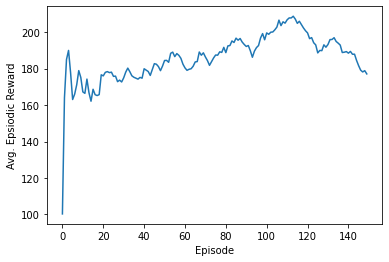

In [11]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(num_actions, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() #+ noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 150
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(50000, 64)

# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    steps = 0
    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)[0]
        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # End this episode when `done` is True
        if done:
            break

        prev_state = state
        steps += 1

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {}/{} * Avg Reward is ==> {}".format(ep, steps, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()